- Fecha: 20/October/2021 - Wednesday
- Autor: Virgilio Murillo Ochoa
- personal github: Virgilio-AI
- linkedin: https://www.linkedin.com/in/virgilio-murillo-ochoa-b29b59203
- contact: virgiliomurilloochoa1@gmail.com


- Modificado 4 de Noviembre
- Autor: Juan Marquina Cancino

# Enunciado del problema
Se tienen $N$ tareas y $M$ maquinas. Cada tarea tiene que ser completada una vez, y cualquier máquina puede realizar cualquier tarea, y varias máquinas pueden trabajar al mismo tiempo.

<br>
Adicional a esto, cada máquina tiene un tiempo de ajuste $t_{ij}$, que hay que esperar para realizar la tarea ${j}$, inmediatamente depuses de la tarea ${i}$.


Dados los tiem${}$pos de procesamiento de cada tarea, si se fuese a realizar por cierta máquina, y los tiemp${}$os de espera, hay que minimizar la cantidad de tiempo necesario para completar todas las tareas. ${}$

In [21]:
import re
import numpy as np

In [3]:
from Utils.plot_utils import setup_graphs
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm

In [4]:
def obtener_datos_archivo(nombre):
    r"""
    Lee los datos del archivo {nombre}.sjupm. Devuelve el numero de maquinas,
    numero de ordenes, matriz de tiempo de procesamiento por maquina, y matriz de
    tiempo de ajuste por maquina
    
    Se espera que el archivo contenga al inicio dos numeros (N, M) el numero de ordenes
    y el numero de maquinas. 
    Despues siguen M lineas, una por cada maquina, con N numeros cada linea, representando el 
    tiempo de procesamiento cada tarea si fuese realizada por esa maquina.
    
    Despues siguen M matricez, una por cada maquina, donde cada matriz tiene tamanio N*N
    donde el valor de la fila i, columna j, representa el tiempo de ajuste de 
    pasar de la tarea i => j 
    
    """
    with open(f'{nombre}.sjupm', 'r') as file:
        lines = list(line for line in (l.strip() for l in file) if line)
    numeros = lines[0]

    # colocar en lista el número de máquinas y de órdenes
    numbers = [int(s) for s in numeros.split() if s.isdigit()]
    # print(numbers)
    nMaquinas = numbers[1]
    nOrdenes = numbers[0]
    lines = lines[1:]  # remover encabezado de números

    tiemposMaquina = []

    for i in range(nMaquinas):
        numbersLinesMaquinas = [int(s)
                                for s in lines[i].split() if s.isdigit()]
        tiemposMaquina.append(numbersLinesMaquinas)

    lines = lines[nMaquinas:]
    
    tiemposAjuste = []
    for i in range(nMaquinas):
        tiemposAjuste.append([])
        tiemposAjusteMaquina = []
        for j in range(nOrdenes):
            numbersTiemposAjuste = [int(s)
                                    for s in lines[j].split() if s.isdigit()]
            tiemposAjusteMaquina.append(numbersTiemposAjuste)
        tiemposAjuste[i] = tiemposAjusteMaquina
        lines = lines[nOrdenes:]
        
    return nMaquinas, nOrdenes, tiemposMaquina, tiemposAjuste


In [5]:
def obtener_datos_consola():
    r"""
    No esta optimizado a velocidad, no usar para pruebas, usar la version que lee de archivo
    
    Lee los datos de consola. Devuelve el numero de maquinas,
    numero de ordenes, matriz de tiempo de procesamiento por maquina, y matriz de
    tiempo de ajuste por maquina
    
    Se espera que el archivo contenga al inicio dos numeros (N, M) el numero de ordenes
    y el numero de maquinas. 
    Despues siguen M lineas, una por cada maquina, con N numeros cada linea, representando el 
    tiempo de procesamiento cada tarea si fuese realizada por esa maquina.
    
    Despues siguen M matricez, una por cada maquina, donde cada matriz tiene tamanio N*N
    donde el valor de la fila i, columna j, representa el tiempo de ajuste de 
    pasar de la tarea i => j 
    
    """ 
    Input = input()
    Input = re.findall(r"[\w']+", Input)
    nMaquina = int(Input[1])
    nOrdenes = int(Input[0])
    # remover numeros leidos
    Input = Input[2:]
    
    tiemposMaquina = []
    for i in range(nMaquina):
        tiemposMaquina.append(Input[:nOrdenes])
        Input = Input[nOrdenes:]
    #convertir tiemposMaquina a enteros
    for i in range(nMaquina):
        for j in range(nOrdenes):
            tiemposMaquina[i][j] = int(tiemposMaquina[i][j])
    
    tiemposAjuste = []
    for i in range(nMaquina):
        tiemposAjusteMaquina = []
        for j in range(nOrdenes):
            tiemposAjusteMaquina.append(Input[:nOrdenes])
            Input = Input[nOrdenes:]
        tiemposAjuste.append(tiemposAjusteMaquina)
    
    for i in range(nMaquina):
        for j in range(nOrdenes):
            for k in range(nOrdenes):
                tiemposAjuste[i][j][k] = int(tiemposAjuste[i][j][k])
        
    return nMaquinas, nOrdenes, tiemposMaquina, tiemposAjuste

In [6]:
def solucionAleatoria(nMaquinas, nOrdenes):
    r"""
    Regresa un vector de tamanio (nMaquinas - 1 + nOrdenes). El vector va a tener (nMaquina - 1)
    elementos iguales a -1, que representan los separadores, y (nOrdenes) elementos que conformen
    una permutaciones de 0 -> nOrdenes - 1
    
    Cada solucion aleatoria es unica, y tienen la misma probabilidad
    """
    rng = np.random.default_rng()
    X = rng.permutation(np.concatenate((np.arange(nOrdenes), np.ones(nMaquinas-1)*-1), axis = None))
    X = X.tolist()
    X = [int(x) for x in X]
    return X

In [7]:
def generarVecino(X):
    r"""
    Genera un nuevo vetor Y, a partir de una solucion X.
    Toma la ultima tarea de una maquina, y la pone al final de la lista de tareas de cualquier otra maquina
    """
    
    # Genero lista de adyacencia a partir de solucion
    adjacencyList = []
    tempList = []
    for x in X:
        if(x == -1):
            adjacencyList.append(tempList)
            tempList = []
        else:
            tempList.append(x)
    adjacencyList.append(tempList)
    
    # Contar cantidad de maquinas, con listas de trabajo no vacias
    machinesWorking = 0
    nMachines = len(adjacencyList)
    for i in range(nMachines):
        if(len(adjacencyList[i]) != 0):
            machinesWorking += 1
    
    # Escoger una de esas maquinas
    rng = np.random.default_rng()
    randomMachine = int(rng.random()*machinesWorking)
    it = 0
    while(randomMachine >= 0):
        if(len(adjacencyList[it]) == 0):
            it += 1
            continue
        if(randomMachine == 0):
            indexRandom = it
            break
        else:
            it += 1
            randomMachine -= 1
    
    num = adjacencyList[it][-1]
    adjacencyList[it] = adjacencyList[it][:-1]
    
    # Selecionar otra maquina, y agregarle la tarea
    randomMachine = int(rng.random()*(nMachines-1))
    if(randomMachine >= it):
        randomMachine += 1
    adjacencyList[randomMachine].append(num)
    
    # Regresar a la representacion de un solo vector
    Y = []
    primero = True
    for vec in adjacencyList:
        if(primero == False):
            Y.append(-1)
        primero = False
        Y.extend(vec)
    return Y

In [8]:
def funcionObjetivo(X, tiempoProcesamiento, tiempoAjuste):
    r"""
    Calcula el tiempo en el que las maquinas acabaran con todas las tareas, dado cierto acomodo
    X
    """
    x = 0
    y = 0
    ans = 0
    prev = -1
    for i in range(len(X)):
        if(X[i] == -1):
            x = x + 1
            y = 0
            prev = -1
        else:
            if(prev != -1):
                y += tiempoAjuste[x][X[i-1]][X[i]]
            y += tiempoProcesamiento[x][X[i]]
            ans = max(ans, y)
            prev = 1
    return ans

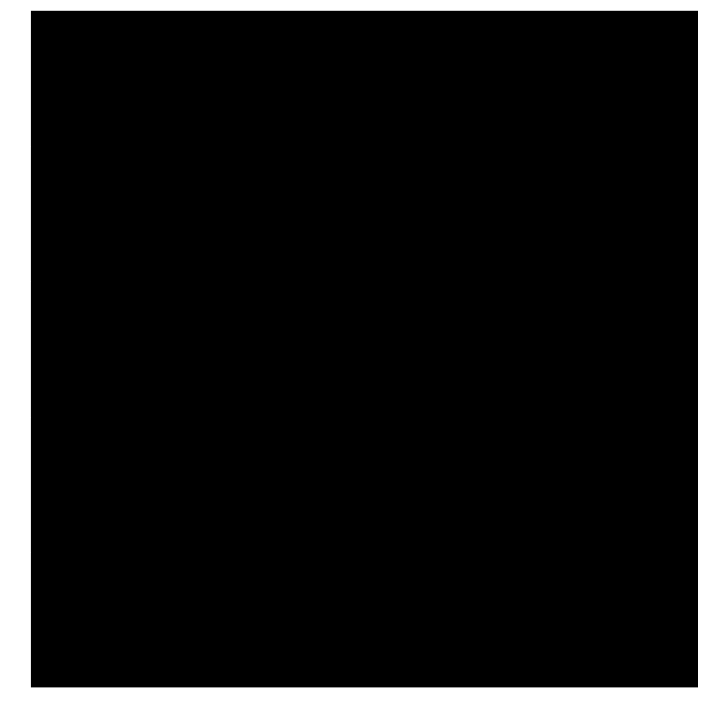

In [9]:
def imprimirSolucion(X, tiempoProcesamiento, tiempoAjuste, ax = setup_graphs()):
    r"""
    Para cada maquina, dibuja una grafica de barras que representa las tareas hechas y el tiempo
    total de procesamiento.
    
    Al final regresa la grafica
    """    
    jet = plt.get_cmap('BuPu')
    colors = jet((np.linspace(0, 1, 13)))
    colors = colors[::-1]
    prev = -1
    xAxis = .8
    yAxis = 0
    x = 0
    colorIndex = 0
    ansC = 0
    ans = 0
    for i in range(len(X)):
        if(X[i] == -1):
            prev = -1
            x = x + 1
            xAxis = xAxis + 1
            yAxis = 0
            colorIndex = 0
        else:
            if(prev != -1):
                tiempoExtra = tiempoAjuste[x][X[i-1]][X[i]]
                ax.bar(x = xAxis, height = tiempoExtra, bottom = yAxis, color = colors[colorIndex])
                yAxis += tiempoExtra
                if(colorIndex >= len(colors) - 1):
                    colorIndex = 0
            prev = X[i]
            tiempoPros = tiempoProcesamiento[x][X[i]]
            ax.bar(x = xAxis, height = tiempoPros, bottom = yAxis, color = colors[colorIndex])
            yAxis += tiempoPros
            colorIndex += 1
            if(colorIndex >= len(colors) - 1):
                colorIndex = 0
            ans = max(ans, yAxis)
            ansC = max(ansC, colorIndex)
    ax.axhline(y = ans, color = colors[ansC], linestyle = "dashed",linewidth = 4)
    return ax

## Modelado del problema

En este problema, una solución puede ser representada con un vector $\bf{X} \in \mathbb{R}^{N+M-1}$, donde $N$ representa el número de tareas y $M$ el numero de máquinas.


El vector $\bf{X}$ tiene que cumplir con la propiedad de que $M-1$ elementos sean igual a -1 y los $N$ elementos restantes son una permutacion de los numeros de 0 a N-1.

Por ejemplo si $N = 10, M = 3$, una posible solución seria $X = \{\,3,\, 2, \,6,\, -1,\, 1,\, 0,\, -1,\, 9,\, 7,\, 8,\, 5\,\}$



### Como interpretamos este vector? 
Imaginemos que si $X_i = -1$ hay un separador en la posición $i$. La maquina 1, va a realizar todas la tareas del inicio hasta el primer separador, en el orden ya asignado, la maquina 2 realiza las tarea del primer separador, al segundo separador separador, la maquina $i$ realiza las tareas del separador $i-1$ hasta el separador $i$ y la ultima maquina $M$ realiza las tareas del separador $M-1$ hasta el final.

#### Ejemplo:
Por ejemplo si $X = \{\,3,\, 2, \,6,\, -1,\, 1,\, 0,\, -1,\, 9,\, 7,\, 8,\, 5,\, 4 \, \}$ entonces:
      
      Máquina 1: 3, 2, 6
      Máquina 2: 1, 0
      Máquina 3: 9, 7, 8, 5, 4


#### Dato Curioso:
Para cada solución del problema hay una única representación $\bf{X}$, y cada vector $\bf{X}$ corresponde a una única solución del problema, por lo que podemos contar la cantidad de posibles soluciones que tiene el problema. 
$$ cantidadSoluciones = N!*{N+M-1 \choose M-1} $$

Si $N=10, \, M= 3 \rightarrow  cantidadSoluciones = 239,500,800$

In [10]:
#Entrada ejemplo para 3 maquinas y 10 tareas
entradaEjemplo = [3, 2, 6, -1, 1, 0, -1, 9, 7, 8, 5, 4]

# Solucion inicial/ Inicializacion Aleatoria
Generar una solucion aleatoria simplemente es generar el un vector con las caracteristicas mencionadas anteriormente

In [11]:
# Tip: Presiona shift + tab dentro de una funcion para ver su descripcion

# entrada aleatoria para 3 maquinas y 10 tareas/ordenes
entradaAleatoria = solucionAleatoria(3, 10)
print(entradaAleatoria)

[-1, 4, 1, 6, 2, 9, 0, 5, 7, 8, -1, 3]


# Soluciones vecinas
En el recocido simulado, se necesita que a partir de una solución previa, se genere una solución vecina.

Proponemos como algoritmo para escoger la solución vecina lo siguiente:

    1.- Escogemos la ultima tarea a realizar de alguna máquina
    2.- La agregamos al final de la lista de tareas de cualquier otra maquina 

### Ejemplos:
Por ejemplo si nuestro vector inicial fuese $\bf{X} = \{\,3,\, 2, \,6,\, -1,\, 1,\, 0,\, -1,\, 9,\, 7,\, 8,\, 5,\, 4 \,\}$, podemos visualizarlo como:
> Maquina 1: 3, 2, 6

> Maquina 2: 1, 0

> Maquina 3: 9, 7, 8, 5, 4

Podriamos agarrar el ultimo elemento de la Maquina 3, y moverlo a la maquina 1

> Maquina 1: 3, 2, 6, 4

> Maquina 2: 1, 0

> Maquina 3: 9, 7, 8, 5

y nuestro vector quedaria $\bf{X} = \{\,3,\, 2, \,6,\, 4,\, -1,\, 1,\, 0,\, -1,\, 9,\, 7,\, 8,\, 5\, \}$.
Cabe destacar que hay varias posibilidades con la misma probabilidad de ocurrir, por ejemplo pudimos haber agarrado el ultimo de elemento de cualquier maquina, y moverlo al fin${}$al de cualquier otra ma${}$quina

In [12]:
entradaModificada = generarVecino(entradaEjemplo)
print(entradaEjemplo)
print(entradaModificada)

[3, 2, 6, -1, 1, 0, -1, 9, 7, 8, 5, 4]
[3, 2, 6, 0, -1, 1, -1, 9, 7, 8, 5, 4]


## Funcion Objetivo
La funcion objetivo simplemente consistira en calcular cuanto tiempo se tardan las maquinas en acabar con todas las ordenes (suponiendo que trabajan en paralelo)

Por ejemplo, voy a usar los tiempos de Procesamiento, y los tiempos de ajuste de la Instancia 2, para calcular la funcion objectivo de un ejemplo


In [13]:
nMaquinas, nOrdenes, tiemposProcesamiento, tiemposAjuste = obtener_datos_archivo("Instancia2")
entradaAleatoria = solucionAleatoria(nMaquinas, nOrdenes)
print(entradaAleatoria)
print(funcionObjetivo(entradaAleatoria, tiemposProcesamiento, tiemposAjuste))


[6, 7, 2, 0, 3, 1, 9, 8, -1, 4, -1, 5]
273


Text(0.5, 1.0, 'Visualizacion funcion objetivo')

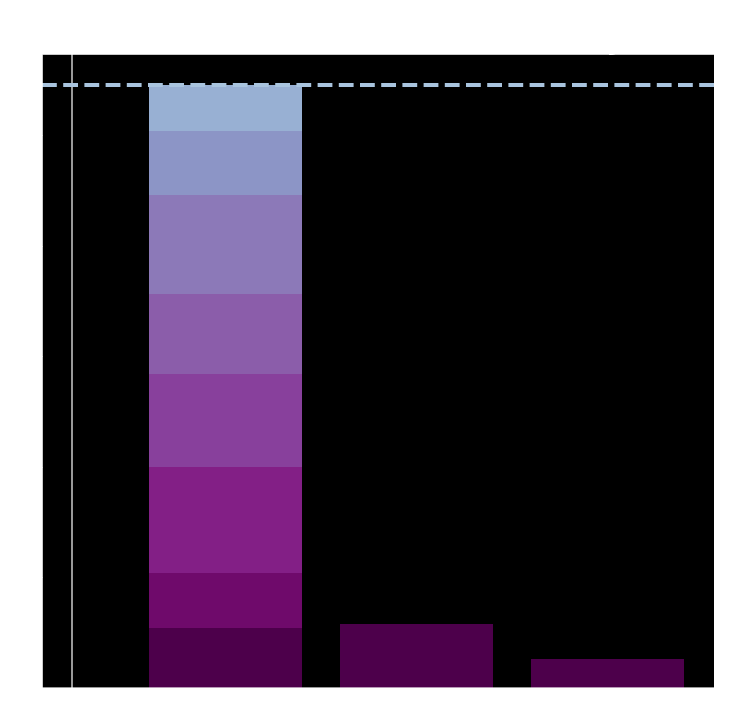

In [14]:
#Tambien podemos visualizar la funcion objetivo de la entrada
ax = setup_graphs()
imprimirSolucion(entradaAleatoria, tiemposProcesamiento, tiemposAjuste, ax)
ax.set_title("Visualizacion funcion objetivo", size = 50, c = (1,1,1))

## Recocido Simulado


In [147]:
def recocidoSimulado(nMaquinas, nOrdenes, tiempos, ajustes,
                     fInicializar, fModificar, fObjetivo, 
                     it=100, T=10, limT=1e-8, reduccionT=0.99):
    r"""
    Devuelve la mejor solucion, y una lista de soluciones intermedias del recocido simulado.
    Primero se inicializa una solucion con fInicializar.
    Despues, en cada paso se genera un vector vecino con fModificar, y se saca su 
    valor con fObjectivo.
    
    Si la nueva solucion pasa el criterio, se agrega a las soluciones intermedias, y a partir de
    esa solucion se generan los siguientes vecotres vecinos
    """
    
    solucion = fInicializar(nMaquinas, nOrdenes)
    
    #soluciones intermedias 
    intermedias = []
    intermedias.append(solucion)
    
    for i in range(it):
        if(T < limT):
            return solucion
        propuesta = fModificar(intermedias[-1])
        valorPropuesta = fObjetivo(propuesta, tiempos, ajustes)
        valorAnterior = fObjetivo(intermedias[-1], tiempos, ajustes)
        # Criterio de evaluacion
        if(valorPropuesta < valorAnterior):
            intermedias.append(propuesta)
        elif(np.random.uniform() < np.exp(valorAnterior - valorPropuesta)/T):
            intermedias.append(propuesta)
        else:
            intermedias.append(intermedias[-1])
            
        if(fObjetivo(propuesta, tiempos, ajustes) < fObjetivo(solucion, tiempos, ajustes)):
            solucion = propuesta
        
        T = reduccionT*T
            
    return solucion, intermedias


            
        
    

## Experimentacion
Se ejecuto el recocido simulado 50 veces, con 1000 iteraciones en cada ejecucion. En todas las ejecuciones se utilizaron los mismos valores. La temeperatura inicial es de 10, con fun factor de reduccion de 0.99

Despues de esas 50 ejecuciones se calculó el maximo, minimo, promedio y desviación estandar. Tambien se generaron graficas para la mejor y peor ejecución.


In [148]:
nMaquinas, nOrdenes, tiemposProcesamiento, tiemposAjuste = obtener_datos_archivo("Instancia2")

T = 10
it = 1000
limT=1e-8
reduccionT=0.99
ejecuciones = 50

resultados = []
#Ejecutar
for k in range(ejecuciones):
    resultados.append(recocidoSimulado(nMaquinas, nOrdenes, tiemposProcesamiento, tiemposAjuste,
                        solucionAleatoria, generarVecino, funcionObjetivo, it, T, limT, reduccionT))


In [149]:
# Analizar ejecuciones
indiceMinimo = 0
valorMinimo = funcionObjetivo(resultados[0][0], tiemposProcesamiento, tiemposAjuste)
indiceMaximo = 0
valorMaximo = 0
promedio = 0
varianza = 0

# Calular minimo, maximo y promedio
for i ,(ans, inter) in enumerate(resultados):
    if(funcionObjetivo(ans, tiemposProcesamiento, tiemposAjuste) < valorMinimo):
        indiceMinimo = i
        valorMinimo = funcionObjetivo(ans, tiemposProcesamiento, tiemposAjuste)
    if(funcionObjetivo(ans, tiemposProcesamiento, tiemposAjuste) > valorMaximo):
        indiceMaximo = i
        valorMaximo = funcionObjetivo(ans, tiemposProcesamiento, tiemposAjuste)
    promedio += funcionObjetivo(ans, tiemposProcesamiento, tiemposAjuste)
    
promedio /= ejecuciones

# Calcular varianza
for i ,(ans, inter) in enumerate(resultados):
    varianza += (funcionObjetivo(ans, tiemposProcesamiento, tiemposAjuste) - promedio)**2

varianza /= ejecuciones

desviacion = np.sqrt(varianza)

print("Minimo:", valorMinimo, sep = '\t\t\t')
print("Maximo:", valorMaximo, sep = '\t\t\t')
print("Promedio:", promedio, sep = '\t\t')
print("Desviación estandar:", desviacion, sep = '\t')
    
        

Minimo:			92
Maximo:			130
Promedio:		109.14
Desviación estandar:	8.515891027954739


Text(0.5, 1.0, 'Peor Resultado')

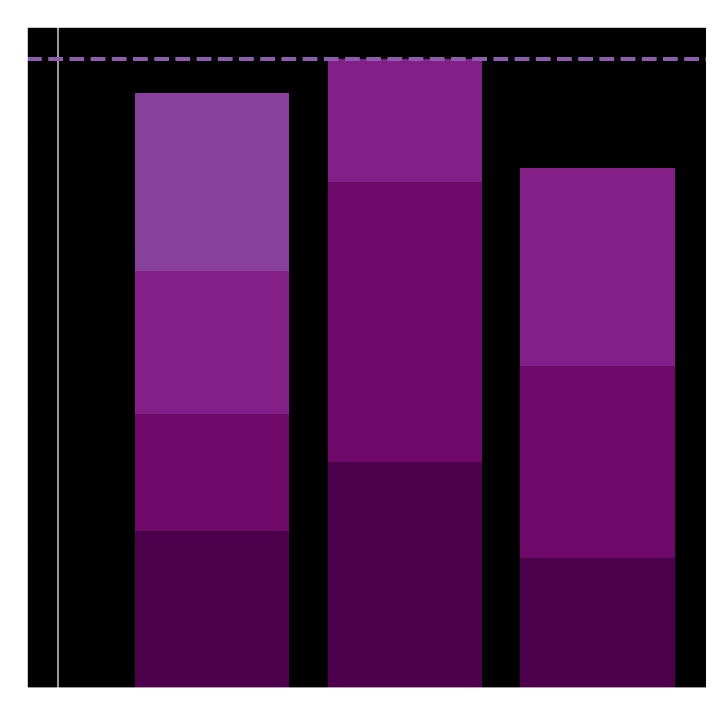

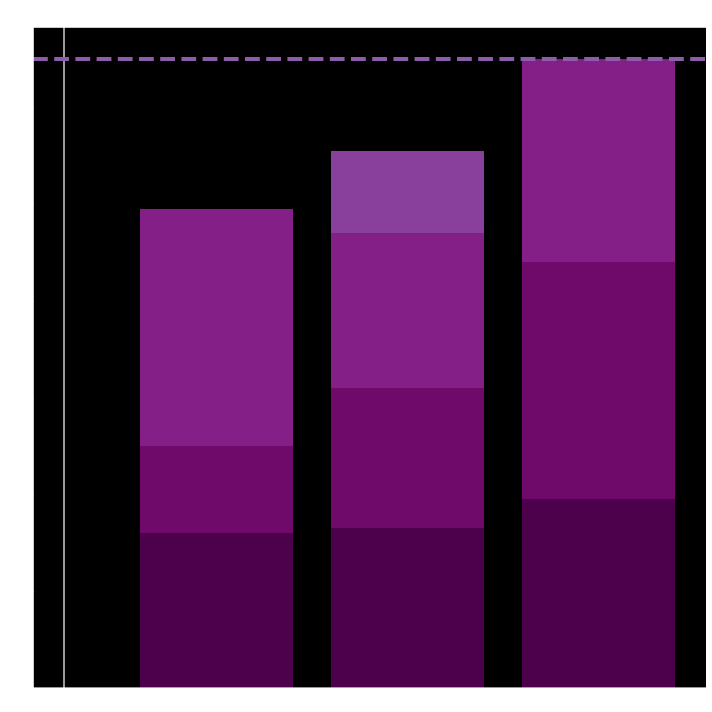

In [150]:
#Visualizar peor y mejor solucion
minimoGrafica = setup_graphs()
imprimirSolucion(resultados[indiceMinimo][0], tiemposProcesamiento, tiemposAjuste, minimoGrafica)
minimoGrafica.set_title("Mejor Resultado", size = 20, c = (1,1,1))

maximoGrafica = setup_graphs()
imprimirSolucion(resultados[indiceMaximo][0], tiemposProcesamiento, tiemposAjuste, maximoGrafica)
maximoGrafica.set_title("Peor Resultado", size = 20, c = (1,1,1))

Text(0.5, 1.0, 'Movimiento intermedio')

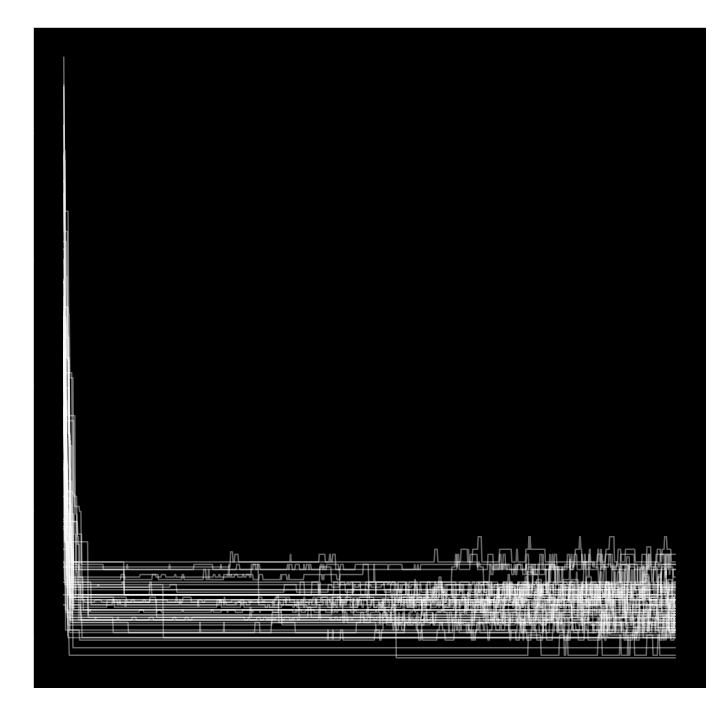

In [151]:
# Graficas de iteraciones intermedias

ax = setup_graphs(1, False)
for (_, inter) in resultados:    
    y = [funcionObjetivo(x, tiemposProcesamiento, tiemposAjuste) for x in inter]
    x = np.arange(len(y))

    ax.plot(x,y, c = (1,1,1,.4))
#print(x, y)
ax.set_title("Movimiento intermedio", size = 20, color = (1,1,1))

Text(0.5, 1.0, 'Movimiento intermedio 4ta ejecucion')

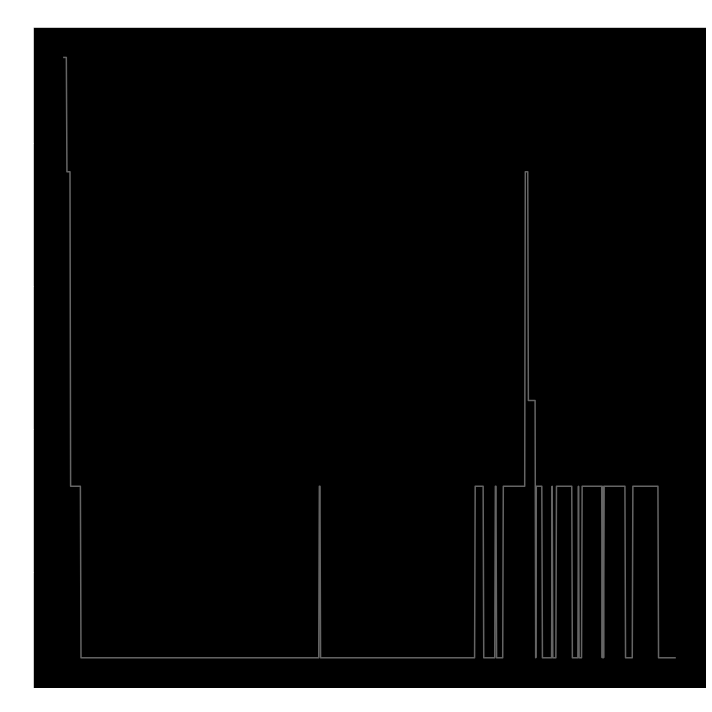

In [152]:
#Graficas de movimiento intermedio, pero  solo del 4to resultado
ax = setup_graphs(1, False)
for (_, inter) in resultados[3:4]:    
    y = [funcionObjetivo(x, tiemposProcesamiento, tiemposAjuste) for x in inter]
    x = np.arange(len(y))

    ax.plot(x,y, c = (1,1,1,.4))
#print(x, y)
ax.set_title("Movimiento intermedio 4ta ejecucion", size = 20, color = (1,1,1))

# Busqueda Taboo

La busqueda taboo nos permite guardar en memoria características de soluciones previas, y obliga que las iteraciones siguientes tambien tengan esas mismas características.

Ya que la busqueda taboo nos ayuda a que nuestras iteraciones tengan caracterisiticas similares, podemos utilizar una funcion de vecindad más *disruptiva* 

# Funcion de vecindad

La funcion de vecindad $N(X)$ son todos los vectores que se puedan conseguir al seguir este algoritmo:
```
1. Escoge un elemento x con posicion i | x != -1
2. Escoge una posicion j != i
3. X[j] = i, X[k+1] = X[k] | (k >= i && k < j) || (k >= j && k<i ) 
```
En español: Agarra un elemento, que no sea un separador, e insertalo en cualquier parte del arreglo. Despues recorre los elementos necesarios para llenar el hueco

Por ejemplo si $X = \{\,3,\, 2, \,6,\, -1,\, 1,\, 0,\, -1,\, 9,\, 7,\, 8,\, 5,\, 4 \, \}$ entonces:
      
      Máquina 1: 3, 2, 6
      Máquina 2: 1, 0
      Máquina 3: 9, 7, 8, 5, 4
Podemos generar un vecino escogiendo a $ x = 0, i = 6, j = 3$. Es decir, movemos el elemento en la posicion 6  a la posicion 3 y recorremos los elementos de enmedio 
Nos quedaria:
```
      Máquina 1: 3, 2, 0, 6
      Máquina 2: 1, 
      Máquina 3: 9, 7, 8, 5, 4
```
Que en forma de vector, se veria como $X = \{\,3,\, 2, \,0,\, 6,\, -1,\, 1,\, -1,\, 9,\, 7,\, 8,\, 5,\, 4 \, \}$ 

In [71]:
def vecindarioTaboo(X):
    r"""
    Devuelve todas los vecindarios de X siguiendo el siguiente algoritmo:
    Escoge un elemento de X (que no sea separador) e insertalo en cualquier otra posicion
    """
    V = []
    for i in range(len(X)):
        for j in range(len(X)):
            if(i == j or X[i] == -1):
                continue
            if(i > j):
                Y = X[0: j]
                Y.append(X[i])
                Y.extend(X[j : i])
                Y.extend(X[i+1 :])
                V.append((Y, X[i]))
            elif(j > i):
                Y = X[0 : i]
                Y.extend(X[i+1 : j+1])
                Y.append(X[i])
                Y.extend(X[j+1 :])
                V.append((Y, X[i]))
    return V

#X = [0, 1, 2, -1, 3, 4, -1, 5, 6, 7, 8, 9]
#print(len(X))
#V = vecindarioTaboo(X)
#print(len(V))
#print()
#print((V[11]))

# Funcion Taboo

La funcion Taboo $f(X, Y, T)$ checa si una propuesta regresa verdadero si se cumple que:
$$ g(t_i, X) = g(t_i, Y)\, \, \, \forall \, \, t_i \in T $$

Donde $X$ es la solucion anterior, $Y$ es la solucion propuesta, $g(i, X)$ es el número de maquina que hace la tarea $i$, en la propuesta $X$, y $T$ es la lista taboo.

## Que se agrega a la lista taboo?
$T$ es un vector vacio inicialmente. En cada iteracion, se caclula el mejor vecino de la solucion previa $X$ que cumpla con el criterio taboo, y lo llamamos $Y$. Acordemonos que $Y$ se generó de mover un único elemento $x$, ese elemento $x$ lo agregamos a nuestra lista taboo

### En otras palabras
Si una tarea está en la lista tabú, esta tarea no puede ser asignada a otra máquina.

Si se cambia el orden/maquina de una tarea, se agrega a la lista tabú 

In [126]:
def grupo(x, X):
    r"""
    Recibe una tarea, y una solucion. 
    Devuelve el indice de la maquina que haria la tarea x. (Contando desde el 0)
    """
    maquina = 0
    for y in X:
        if(y == x):
            return maquina
        if(y == -1): 
            maquina += 1
    return maquina

def criterioTaboo(X, Y, T):
    r"""
    Recibe la solución anterior, la propuesta y la lista Taboo.
    Checa que todos los elementos que esten en la lista taboo cumplan con la siguiente 
    condicion: Si un elemento t, fue asignado a la maquina m, entonces en la propuesta
    ese mismo elemento t, tiene que ser asignado a la misma maquina m.
    """
    for t in T:
        if(grupo(t, X) != grupo(t, Y)):
            return False
    return True
#X = [0, 1, 2, -1, 3, 4, -1, 5, 6, 7, 8, 9]
#print(len(X))
#V = vecindarioTaboo(X)
#T = [-1, -1]
#for v, index  in V:
#    print(criterioTaboo(X, v, T))

# Algoritmo Tabú

In [161]:
def tabooSearch(nMaquinas, nOrdenes, tiempos, ajustes,
                     fInicializar, fVecindario, fObjetivo, 
                it = 100, T = [-1, -1, -1]):
    XBest = fInicializar(nMaquinas, nOrdenes)
    XPrev = XBest
    
    
    intermedias = []
    intermedias.append(XPrev)
    for k in range(it):
        V = fVecindario(XPrev)
        mejorIteracion = 0
        mejorIndex = 0
        primerSolucion = True
        
        
        for v, index in V:
            #checar si es mejor que la solucion global
            if(fObjetivo(v, tiempos, ajustes) < fObjetivo(XBest, tiempos, ajustes)):
                XBest = v
            
            # checar si cumple con el criterion taboo y si es mejor que la mejorIteracion
            if(criterioTaboo(XPrev, v, T) and 
               (primerSolucion or fObjetivo(mejorIteracion, tiempos, ajustes) >
               fObjetivo(v, tiempos, ajustes))):
                mejorIteracion = v
                mejorIndex = index
                primerSolucion = False
            
        XPrev = mejorIteracion
        intermedias.append(XPrev)
        T.append(mejorIndex)
        T = T[1:]
    return XBest, intermedias

# Experimentacion
Se ejecuto el algoritmo tabú 50 veces, con 100 iteraciones en cada ejecucion. En todas las ejecuciones se utilizaron los mismos valores. El tamaño de la lista tabú fue de 3

Despues de esas 50 ejecuciones se calculó el maximo, minimo, promedio y desviación estandar. Tambien se generaron graficas para la mejor y peor ejecución.


In [170]:

nMaquinas, nOrdenes, tiemposProcesamiento, tiemposAjuste = obtener_datos_archivo("Instancia2")

T = [-1, -1, -1]

it = 100
ejecuciones = 50

resultados = []
for k in range(ejecuciones):
    resultados.append(tabooSearch(nMaquinas, nOrdenes, tiemposProcesamiento, tiemposAjuste,
                        solucionAleatoria, vecindarioTaboo, funcionObjetivo, it, T ))
    T = [-1, -1, -1]




In [175]:
# Analizar ejecuciones
indiceMinimo = 0
valorMinimo = funcionObjetivo(resultados[0][0], tiemposProcesamiento, tiemposAjuste)
indiceMaximo = 0
valorMaximo = 0
promedio = 0
varianza = 0

# Calular minimo, maximo y promedio
for i ,(ans, inter) in enumerate(resultados):
    if(funcionObjetivo(ans, tiemposProcesamiento, tiemposAjuste) < valorMinimo):
        indiceMinimo = i
        valorMinimo = funcionObjetivo(ans, tiemposProcesamiento, tiemposAjuste)
    if(funcionObjetivo(ans, tiemposProcesamiento, tiemposAjuste) > valorMaximo):
        indiceMaximo = i
        valorMaximo = funcionObjetivo(ans, tiemposProcesamiento, tiemposAjuste)
    promedio += funcionObjetivo(ans, tiemposProcesamiento, tiemposAjuste)
    
promedio /= ejecuciones

# Calcular varianza
for i ,(ans, inter) in enumerate(resultados):
    varianza += (funcionObjetivo(ans, tiemposProcesamiento, tiemposAjuste) - promedio)**2

varianza /= ejecuciones

desviacion = np.sqrt(varianza)

print("Minimo:", valorMinimo, sep = '\t\t\t')
print("Maximo:", valorMaximo, sep = '\t\t\t')
print("Promedio:", promedio, sep = '\t\t')
print("Desviación estandar:", desviacion, sep = '\t')
    
        

Minimo:			84
Maximo:			121
Promedio:		96.78
Desviación estandar:	7.457318552938449


Text(0.5, 1.0, 'Peor Resultado')

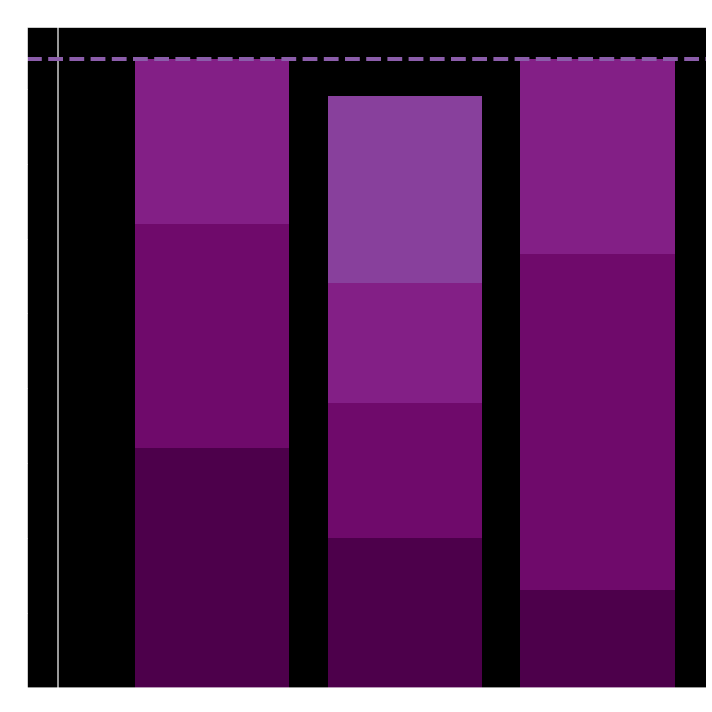

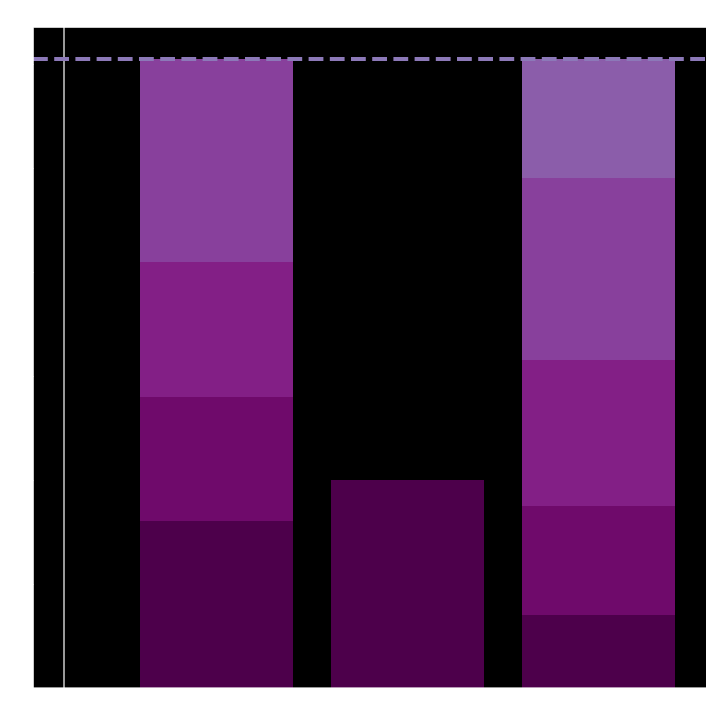

In [172]:
#Visualizar peor y mejor solucion
minimoGrafica = setup_graphs()
imprimirSolucion(resultados[indiceMinimo][0], tiemposProcesamiento, tiemposAjuste, minimoGrafica)
minimoGrafica.set_title("Mejor Resultado", size = 20, c = (1,1,1))

maximoGrafica = setup_graphs()
imprimirSolucion(resultados[indiceMaximo][0], tiemposProcesamiento, tiemposAjuste, maximoGrafica)
maximoGrafica.set_title("Peor Resultado", size = 20, c = (1,1,1))

Text(0.5, 1.0, 'Movimiento intermedio')

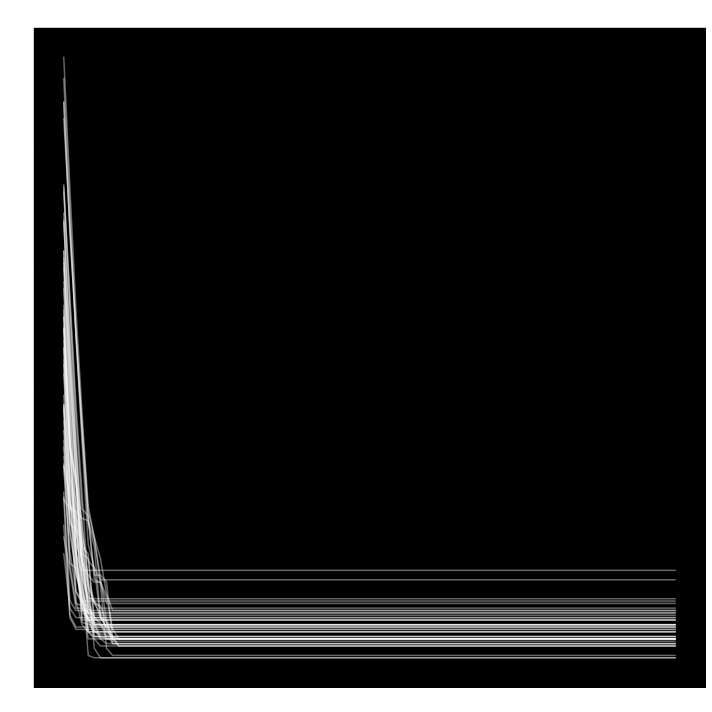

In [173]:
# Graficas de iteraciones intermedias

ax = setup_graphs(1, False)
for (_, inter) in resultados:    
    y = [funcionObjetivo(x, tiemposProcesamiento, tiemposAjuste) for x in inter]
    x = np.arange(len(y))
    ax.plot(x,y, c = (1,1,1,0.4))
#print(x, y)
ax.set_title("Movimiento intermedio", size = 20, color = (1,1,1))

Text(0.5, 1.0, 'Movimiento intermedio 4ta ejecucion')

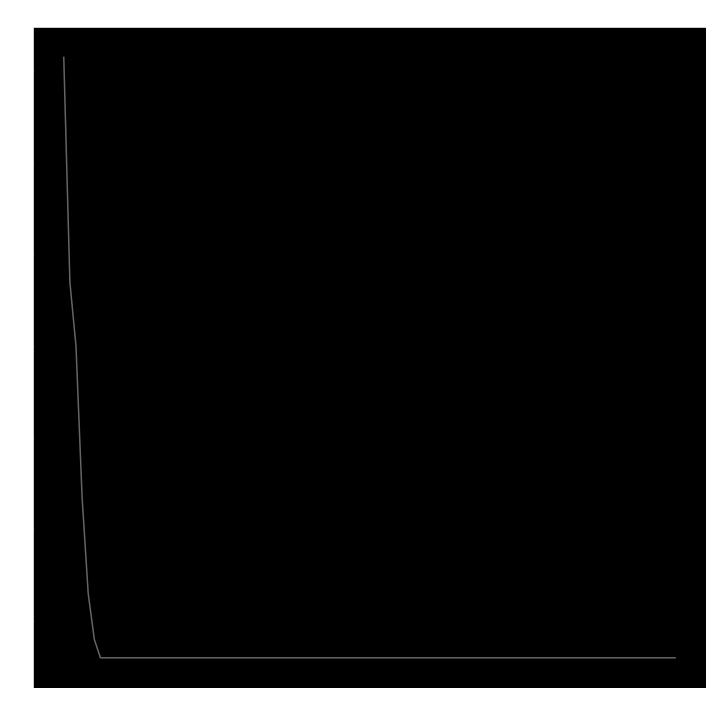

In [174]:
#Graficas de movimiento intermedio, pero  solo del 4to resultado
ax = setup_graphs(1, False)
for (_, inter) in resultados[9:10]:    
    y = [funcionObjetivo(x, tiemposProcesamiento, tiemposAjuste) for x in inter]
    x = np.arange(len(y))
    ax.plot(x,y, c = (1,1,1,.4))
#print(x, y)
ax.set_title("Movimiento intermedio 4ta ejecucion", size = 20, color = (1,1,1))